In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.io as sio
import scipy.sparse as sps

In [2]:
# data_dir = './data'
# mat = sio.loadmat(f'{data_dir}/binarydata.mat')
# X = mat['X']
# X.shape

In [3]:
X = np.array([
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]])
X = X[np.ix_([0, 2, 7, 1, 4, 8, 3, 5, 6],
             [ 0,  4,  5, 15,  8,  9, 12, 13,  7, 10,  1,  2,  3,  6, 11, 14])]

n_clusters = 3
w = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2])
z = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])

In [4]:
def show_matrix(X, no_axes=True):
    ax = plt.imshow(X, cmap='Greys', vmin=0, vmax=X.max())
    if no_axes:
        plt.axis('off')
    return ax

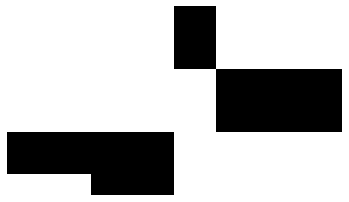

In [5]:
show_matrix(X)

In [6]:
def random_cells(X, n_out):
    """Given an n x r matrix X, returns n_out distinct cell positions
    Parameters
    ----------
    X: np.ndarray or np.matrix, a 2D matrix
    n_out: int, the number of cells to select.
    """
    n, nc = X.size, X.shape[1]
    choices = np.random.choice(n, size=n_out, replace=False)
    rows = choices // nc
    cols = choices % nc
    return rows, cols

In [7]:
def random_missing(X, n_missing):
    r_nan, c_nan = random_cells(X, n_missing)
    res = X.astype(float)
    res[r_nan, c_nan] = np.nan
    return res, r_nan, c_nan

res, r_nan, c_nan = random_missing(X, 10)
print(np.isnan(res).sum())
print(res)

10
[[ 0.  0.  0.  0.  0.  0.  0.  0. nan  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0. nan  0.  0. nan  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1. nan nan  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1. nan nan  1.  1.  1.  0.  0. nan  0. nan  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. nan  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [8]:
z_labels = np.arange(n_clusters)[:, np.newaxis]
w_labels = z_labels

Z = (z == z_labels).T
W = (w == w_labels).T

In [9]:
def summarize_blocks(X, z, wT):
    """get the summary matrix from a contingency matrix X
        with row labels z and column labels w
    Parameters
    ----------
    X: np.array, n x d, contingency table (n rows d, columns)
    z: np.array, n x k, row assignments (n rows, k classes)
    wT: np.array, d x l, transpose of column assignments (d columns, l classes)
    
    Returns
    -------
    for each block i,j return the sum of values in that block, shape k x l
    """
    return z.T @ X @ wT

summarize_blocks(X, Z, W)

array([[ 0,  6,  0],
       [ 0,  0, 18],
       [20,  0,  0]])

In [10]:
def get_block_counts(z, wT):
    """get the count of item in each block of matrix X (n x d)
    Parameters
    ----------
    z: np.array, n x k, row assignments (n rows, k classes)
    wT: np.array, d x l, transpose of column assignments (d columns, l classes)
    
    Returns
    -------
    for each block i,j return the number of items in that block, shape k x l
    """
    return z.sum(axis=0)[:,np.newaxis] * wT.sum(axis=0)

get_block_counts(Z, W)

array([[24,  6, 18],
       [24,  6, 18],
       [24,  6, 18]])

In [11]:
Z.shape, W.shape

((9, 3), (16, 3))

In [12]:
block_rep_vals = summarize_blocks(X, Z, W) / get_block_counts(Z, W)
block_rep_vals

array([[0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.83333333, 0.        , 0.        ]])

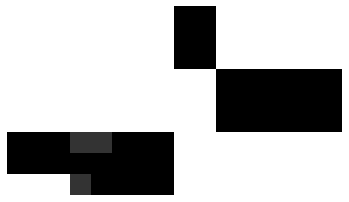

In [13]:
tmp = res.copy()
tmp[r_nan, c_nan] = block_rep_vals[z[r_nan],w[c_nan]]
show_matrix(tmp)

In [14]:
print(np.round(tmp[r_nan, c_nan],2))
print(X[r_nan, c_nan])

[0.   0.83 0.83 1.   0.83 1.   0.   0.   0.   1.  ]
[0 1 0 1 1 1 0 0 0 1]


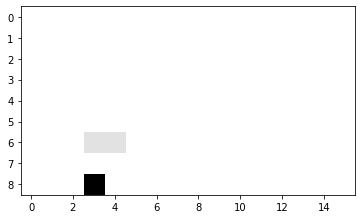

In [15]:
show_matrix(np.abs(X-tmp), no_axes=False)

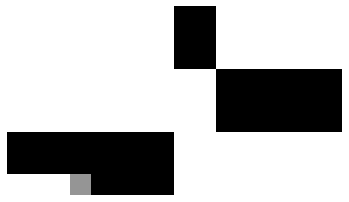

In [16]:
XW = X @ W
# cls = np.argmax(XW, axis=1)
# Z = cls == z_labels
# print(XW)

na_rep = XW / W.sum(axis=0)
# print(np.round(na_rep,5))
X_nan = res.copy()
X_nan[r_nan, c_nan] = (na_rep @ W.T)[r_nan, c_nan]

show_matrix(X_nan)

# print(np.round(W.T @ na_rep,2).T[nan_mask])



In [17]:
print(np.round(X_nan[r_nan, c_nan],2))
print(X[r_nan, c_nan])

[0.  1.  0.5 1.  1.  1.  0.  0.  0.  1. ]
[0 1 0 1 1 1 0 0 0 1]


SSE: 0.25
rounded error matrix


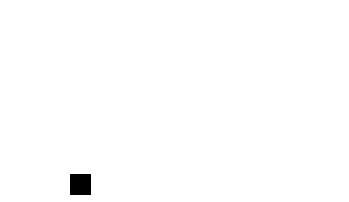

In [18]:
diff = np.abs(X-X_nan)
print(f"SSE: {(diff**2).sum()}")
print("rounded error matrix")
show_matrix(diff)

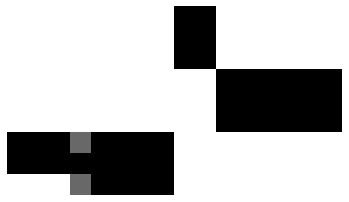

In [19]:
XtZ = X.T @ Z

na_rep = XtZ / Z.sum(axis=0)
# print(np.round(na_rep,5))
X_nan = res.copy()
X_nan[r_nan, c_nan] = (Z @ na_rep.T)[r_nan, c_nan]

show_matrix(X_nan)

In [20]:
print(np.round(X_nan[r_nan, c_nan],2))
print(X[r_nan, c_nan])

[0.   1.   0.67 1.   0.67 1.   0.   0.   0.   1.  ]
[0 1 0 1 1 1 0 0 0 1]


SSE: 0.5555555555555556
rounded error matrix


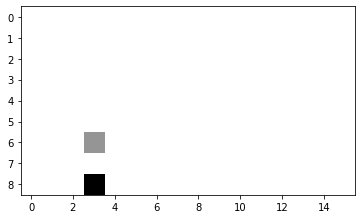

In [21]:
diff = np.abs(X-X_nan)
print(f"SSE: {(diff**2).sum()}")
print("rounded error matrix")
show_matrix(diff, no_axes=False)

## Modification de CoClustMod

In [22]:
# -*- coding: utf-8 -*-

"""
The :mod:`coclust.coclustering.coclust_mod` module provides an implementation
of a co-clustering algorithm by direct maximization of graph modularity.
"""

# Author: Francois Role <francois.role@gmail.com>
#         Stanislas Morbieu <stanislas.morbieu@gmail.com>

# License: BSD 3 clause

import numpy as np
from sklearn.utils import check_random_state, check_array
from joblib import Parallel, delayed, effective_n_jobs

from coclust.initialization import random_init
from coclust.coclustering.base_diagonal_coclust import BaseDiagonalCoclust

'\nThe :mod:`coclust.coclustering.coclust_mod` module provides an implementation\nof a co-clustering algorithm by direct maximization of graph modularity.\n'

In [23]:
def _impute_block_representative(X, Z, W, r_nan, c_nan):
    s = summarize_blocks(X, Z, W)
    bc = get_block_counts(Z, W)
    bc[bc==0] = 1 # avoid divide by 0
    block_rep_vals = s / bc
    X[r_nan, c_nan] = block_rep_vals[z[r_nan],w[c_nan]]
    return X

def _compute_modularity_matrix(X):
    # Compute the modularity matrix
    row_sums = X.sum(axis=1)[:, np.newaxis]
    col_sums = X.sum(axis=0)[np.newaxis, :]
    N = float(X.sum())
    indep = row_sums @ col_sums / N
    
    # B is a numpy matrix
    B = X - indep
    return B, N

In [24]:
def _fit_single(X, n_clusters, impute_fn, r_na, c_na, random_state, init, max_iter, tol, y=None):
    """Perform one run of co-clustering by direct maximization of graph
    modularity.

    Parameters
    ----------
    X : numpy array or scipy sparse matrix, shape=(n_samples, n_features)
        Matrix to be analyzed
    """
    if init is None:
        W = random_init(n_clusters, X.shape[1], random_state)
    else:
        W = np.array(init, dtype=float)

    Z = np.zeros((X.shape[0], n_clusters))

    z_labels = np.arange(n_clusters)
    w_labels = z_labels

    B,N = _compute_modularity_matrix(X)

    modularities = []

    # Loop
    m_begin = float("-inf")
    change = True
    iteration = 0
    while change:
        change = False

        # Reassign rows
        BW = B.dot(W)
        z = np.argmax(BW, axis=1)[:, np.newaxis]
        Z = (z == z_labels)*1

        # Update missing values in X using BW
        X = impute_fn(X, Z, W, r_na, c_na)
        B,N = _compute_modularity_matrix(X)

        # Reassign columns
        BtZ = (B.T).dot(Z)
        w = np.argmax(BtZ, axis=1)[:, np.newaxis]
        W = (w == w_labels)*1
        # for idx, k in enumerate(np.argmax(BtZ, axis=1)):
        #     W[idx, :] = 0
        #     W[idx, k] = 1

        # Update missing values in X using BtZ
        X = impute_fn(X, Z, W, r_na, c_na)
        B,N = _compute_modularity_matrix(X)

        k_times_k = (Z.T).dot(BW)
        m_end = np.trace(k_times_k)
        iteration += 1
        if (np.abs(m_end - m_begin) > tol and
                iteration < max_iter):
            modularities.append(m_end/N)
            m_begin = m_end
            change = True

    row_labels_ = np.argmax(Z, axis=1).tolist()
    column_labels_ = np.argmax(W, axis=1).tolist()
    modularity = m_end / N
    nb_iterations = iteration
    return row_labels_,  column_labels_, modularity, modularities, nb_iterations, X

In [25]:
class CoclustModImpute(BaseDiagonalCoclust):
    """Co-clustering by direct maximization of graph modularity.

    Parameters
    ----------
    n_clusters : int, optional, default: 2
        Number of co-clusters to form

    init : numpy array or scipy sparse matrix, \
        shape (n_features, n_clusters), optional, default: None
        Initial column labels

    max_iter : int, optional, default: 20
        Maximum number of iterations

    n_init : int, optional, default: 1
        Number of time the algorithm will be run with different
        initializations. The final results will be the best output of `n_init`
        consecutive runs in terms of modularity.

    random_state : integer or numpy.RandomState, optional
        The generator used to initialize the centers. If an integer is
        given, it fixes the seed. Defaults to the global numpy random
        number generator.

    tol : float, default: 1e-9
        Relative tolerance with regards to modularity to declare convergence

    Attributes
    ----------
    row_labels_ : array-like, shape (n_rows,)
        Bicluster label of each row

    column_labels_ : array-like, shape (n_cols,)
        Bicluster label of each column

    modularity : float
        Final value of the modularity

    modularities : list
        Record of all computed modularity values for all iterations

    References
    ----------
    * Ailem M., Role F., Nadif M., Co-clustering Document-term Matrices by \
    Direct Maximization of Graph Modularity. CIKM 2015: 1807-1810
    """

    def __init__(self, n_clusters=2, init=None, max_iter=20, n_init=1,
                 tol=1e-9, random_state=None, n_jobs=1):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.n_init = n_init
        self.tol = tol
        self.random_state = random_state
        self.n_jobs = n_jobs
        # to remove except for self.modularity = -np.inf!!!
        self.row_labels_ = None
        self.column_labels_ = None
        self.modularity = -np.inf
        self.modularities = []

    def fit(self, X, impute_fn, initial_vals=None, y=None):
        """Perform co-clustering by direct maximization of graph modularity.

        Parameters
        ----------
        X : numpy array or scipy sparse matrix, shape=(n_samples, n_features)
            Matrix to be analyzed
        """

        random_state = check_random_state(self.random_state)
        
        X = X.astype(float)

        X_ = X.copy()
        r_nan, c_nan = np.where(np.isnan(X_))
        
        if initial_vals:
            X_[r_nan, c_nan] = initial_vals
        else:
            np.random.seed(self.random_state)
#             np.random.rand(r_nan.shape[0]) *
            X_[r_nan, c_nan] = 0

        check_array(X_, accept_sparse=True, dtype="numeric", order=None,
                    copy=False, force_all_finite=True, ensure_2d=True,
                    allow_nd=False, ensure_min_samples=self.n_clusters,
                    ensure_min_features=self.n_clusters,
                    warn_on_dtype=False, estimator=None)

#         if type(X_) == np.ndarray:
#             X_ = np.matrix(X_)

        modularity = self.modularity
        modularities = []
        row_labels = None
        column_labels = None
        seeds = random_state.randint(np.iinfo(np.int32).max, size=self.n_init)
        if effective_n_jobs(self.n_jobs) == 1 or True:
            for seed in seeds:
                new_row_labels,  new_column_labels, new_modularity, new_modularities, new_nb_iterations, new_X_ = _fit_single(
                    X_, self.n_clusters, impute_fn, r_nan, c_nan, seed, self.init, self.max_iter, self.tol, y)
                if np.isnan(new_modularity):
                    raise ValueError(
                        "matrix may contain unexpected NaN values")
                # remember attributes corresponding to the best modularity
                if (new_modularity > modularity):
                    modularity = new_modularity
                    modularities = new_modularities
                    row_labels = new_row_labels
                    column_labels = new_column_labels
                    X_ = new_X_
        else:
            results = Parallel(n_jobs=self.n_jobs, verbose=0)(
                delayed(_fit_single)(X_, self.n_clusters, impute_fn, r_nan, c_nan,
                                     seed, self.init, self.max_iter, self.tol, y)
                for seed in seeds)
            (list_of_row_labels,  list_of_column_labels, list_of_modularity,
             list_of_modularities, list_of_nb_iterations, list_of_imputed_X) = zip(*results)
            best = np.argmax(list_of_modularity)
            row_labels = list_of_row_labels[best]
            column_labels = list_of_column_labels[best]
            modularity = list_of_modularity[best]
            modularities = list_of_modularities[best]
            n_iter = list_of_nb_iterations[best]
            X_ = list_of_imputed_X[best]
            

        # update instance variables
        self.modularity = modularity
        self.modularities = modularities
        self.row_labels_ = row_labels
        self.column_labels_ = column_labels
        self.X_ = X_

        return self

In [26]:
model = CoclustModImpute(n_clusters=3)
X_missing, _, _ = random_missing(X, 30)
print(X_missing)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. nan nan nan  0. nan  1. nan  0.  0. nan  0. nan  0.]
 [ 0. nan  0. nan  0. nan  0.  0. nan  1.  0. nan  0.  0. nan  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1. nan  1. nan nan]
 [nan  0.  0.  0.  0.  0.  0. nan  0.  0. nan  1.  1.  1. nan  1.]
 [ 0. nan  0.  0.  0.  0.  0.  0.  0.  0. nan  1.  1.  1.  1.  1.]
 [ 1. nan  1.  1. nan  1. nan  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1. nan  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. nan  0.  1.  1. nan  1.  0. nan  0.  0.  0.  0.  0. nan]]


In [27]:
model.fit(X_missing, _impute_block_representative)

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.


CoclustModImpute(init=None, max_iter=20, n_clusters=3, n_init=1, n_jobs=1,
                 random_state=None, tol=1e-09)

SSE: 14.2481645912226
rounded error matrix


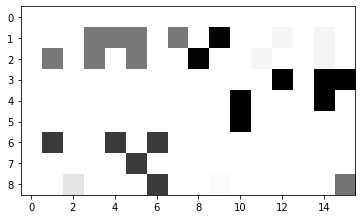

In [28]:
diff = np.abs(X-model.X_)
print(f"SSE: {(diff**2).sum()}")
print("rounded error matrix")
show_matrix(diff, no_axes=False)

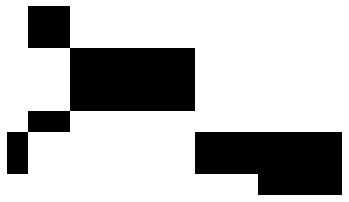

In [29]:
show_matrix(X[np.ix_(np.argsort(model.row_labels_), np.argsort(model.column_labels_))])

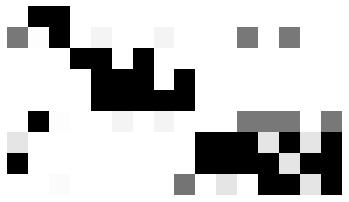

In [30]:
show_matrix(model.X_[np.ix_(np.argsort(model.row_labels_), np.argsort(model.column_labels_))])